Black-Scholes introduced the notion of dynamic delta hedging - by executing delta hedges instantaneously, we ensure that our portfolio is delta neutral, and consequently hedged the exposure of our call position using the underlying stock and the risk-free bond. 

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where 
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

Let us start by defining these stock and bond holding functions:

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt


def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)


def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)


def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)


Next, we shall simulate a single stock price process under the Black-Scholes dynamic, and follow the delta, stock and bond holdings over time until maturity. 

First we generate a single stock price process:

In [2]:
paths = 50_000
steps = 84
maturity = 1/12

T, W_T = simulate_Brownian_Motion(paths, steps, maturity)

r = 0.05
S0 = 100
K = 100
sigma = 0.2
dt = maturity / steps
# blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

We apply this to a call option struck at 100, and today's stock price is also 100. The maturity date is 1 month later, and volatility is 20%.

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_43760/4137336333.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_43760/4137336333.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


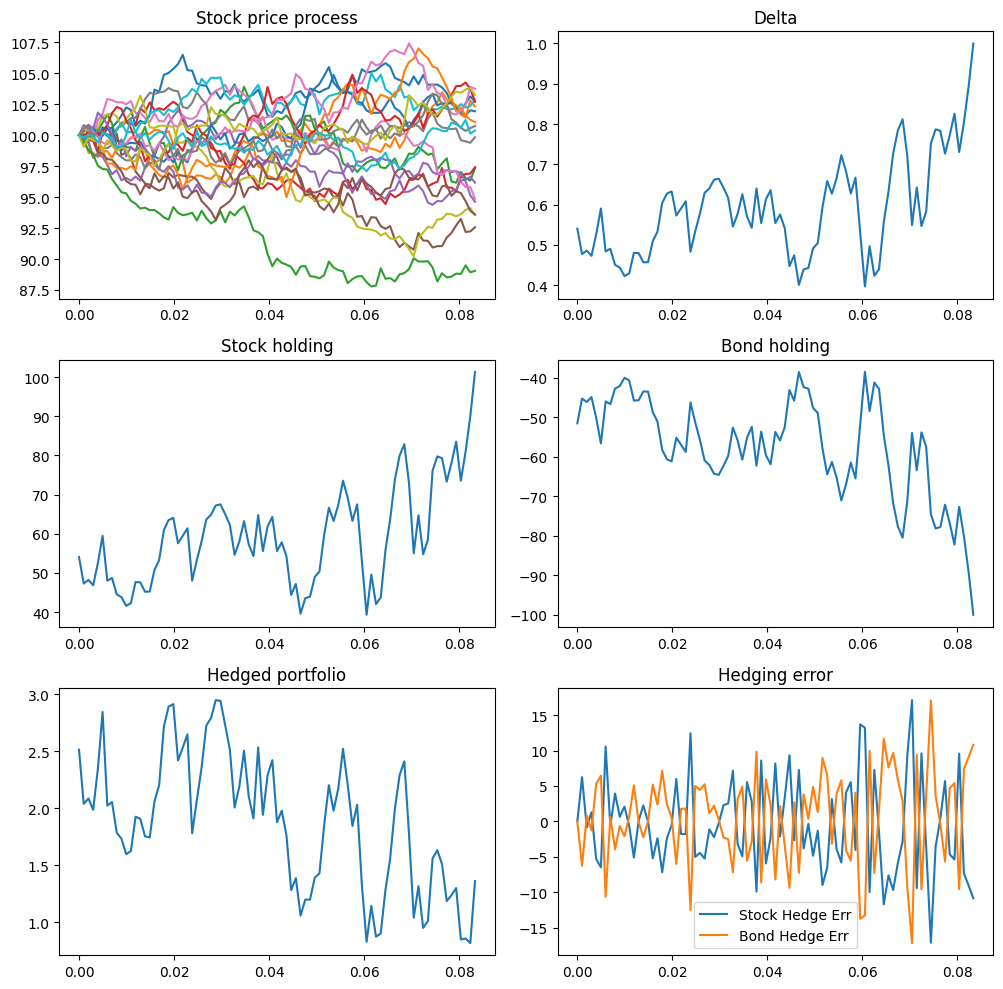

In [3]:
simulated_totalhedge_errors = []

for i in range(paths):
    deltas = []
    stockhedge_errors = []
    bondhedge_errors = []
    hedged_portfolios = []
    stock_holdings = []
    bond_holdings = []
    # set path made by simulation
    blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[i])

    for t, S_t in zip(T, blackscholespath):
        stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
        bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
        V_t = stock_pos + bond_pos
        stock_holdings.append(stock_pos)
        bond_holdings.append(bond_pos)
        hedged_portfolios.append(V_t)
        deltas.append(phi(S_t, K, r, sigma, maturity-t))
        if t == 0.0:
            stockhedge_errors.append(0)
            bondhedge_errors.append(0)
        else:
            stockhedge_errors.append(prev_phi*S_t - stock_pos)
            bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

        prev_phi = phi(S_t, K, r, sigma, maturity-t)
        prev_bond_pos = bond_pos
        
        if t== T[-1]:   # at t = T capture the hedge error
            # simulated_callhedge_errors.append(prev_phi*S_t + prev_bond_pos*np.exp(r*dt) - max(S_t-K,0))
            simulated_totalhedge_errors.append(np.sum(np.array(stockhedge_errors)) + np.sum(np.array(bondhedge_errors)))
                

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
for i in range(20):
    plt.plot(T, S0*np.exp((r-sigma**2/2)*T + sigma*W_T[i]))
plt.title('Stock price process')
plt.subplot(322)
plt.plot(T, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(T, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(T, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(T, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()


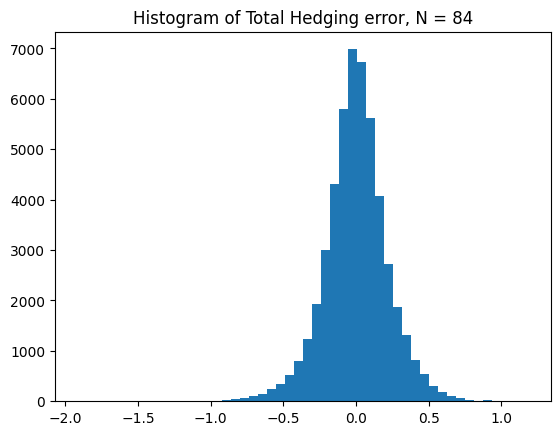

In [4]:
## plot results
plt.hist(simulated_totalhedge_errors,bins=50)
plt.title(f"Histogram of Total Hedging error, N = {steps}");

In [5]:
total_errors = np.array(simulated_totalhedge_errors)
np.mean(total_errors),np.std(total_errors)

(0.00011067496895741058, 0.21771300137605978)

In [6]:
paths = 50_000
steps = 21
maturity = 1/12

T, W_T = simulate_Brownian_Motion(paths, steps, maturity)

dt = maturity / steps
# blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_43760/4137336333.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_43760/4137336333.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))


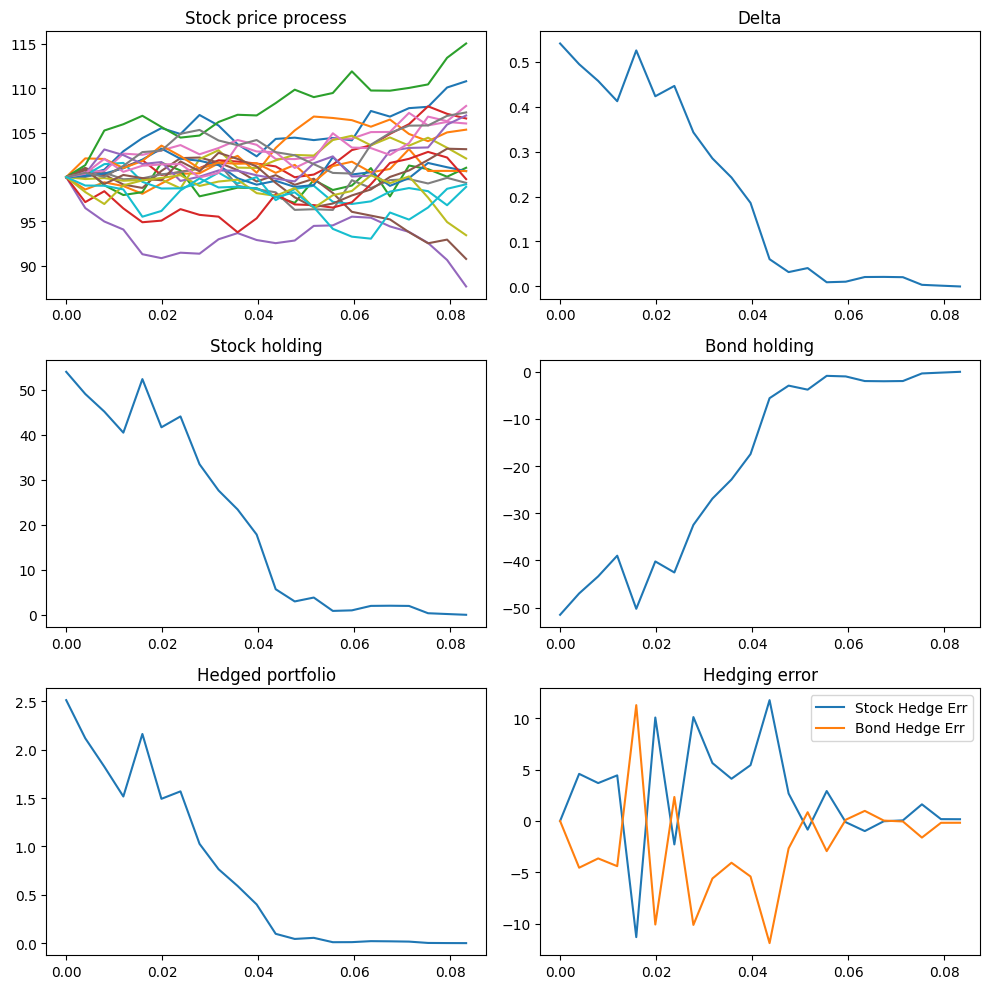

In [7]:
simulated_totalhedge_errors = []

for i in range(paths):
    deltas = []
    stockhedge_errors = []
    bondhedge_errors = []
    hedged_portfolios = []
    stock_holdings = []
    bond_holdings = []
    # set path made by simulation
    blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[i])

    for t, S_t in zip(T, blackscholespath):
        stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
        bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
        V_t = stock_pos + bond_pos
        stock_holdings.append(stock_pos)
        bond_holdings.append(bond_pos)
        hedged_portfolios.append(V_t)
        deltas.append(phi(S_t, K, r, sigma, maturity-t))
        if t == 0.0:
            stockhedge_errors.append(0)
            bondhedge_errors.append(0)
        else:
            stockhedge_errors.append(prev_phi*S_t - stock_pos)
            bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

        prev_phi = phi(S_t, K, r, sigma, maturity-t)
        prev_bond_pos = bond_pos
        
        if t== T[-1]:   # at t = T capture the hedge error
            # simulated_callhedge_errors.append(prev_phi*S_t + prev_bond_pos*np.exp(r*dt) - max(S_t-K,0))
            simulated_totalhedge_errors.append(np.sum(np.array(stockhedge_errors)) + np.sum(np.array(bondhedge_errors)))
                

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
for i in range(20):
    plt.plot(T, S0*np.exp((r-sigma**2/2)*T + sigma*W_T[i]))
plt.title('Stock price process')
plt.subplot(322)
plt.plot(T, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(T, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(T, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(T, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()


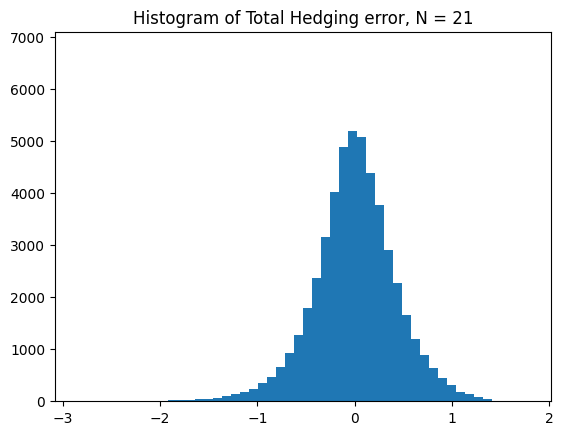

In [12]:
plt.hist(simulated_totalhedge_errors,bins=50)
plt.ylim(0, 7100)
plt.title(f"Histogram of Total Hedging error, N = {steps}");

In [11]:
hedge_errors = np.array(simulated_totalhedge_errors)
np.mean(hedge_errors),np.std(hedge_errors)

(0.0018680869936502286, 0.42729202679069345)

In [7]:
import math

def calculate_vega(S0, K, T, r, sigma):
    """
    Calculate Vega using the Black-Scholes formula.

    Parameters:
    - S0: Spot price of the underlying asset.
    - K: Strike price of the option.
    - T: Time to expiration (in years).
    - r: Risk-free interest rate (annualized, continuous).
    - sigma: Volatility of the underlying asset.

    Returns:
    - Vega (sensitivity of the option price to changes in volatility).
    """
    # Calculate d1
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    
    # Standard normal probability density function (PDF)
    phi_d1 = math.exp(-0.5 * d1**2) / math.sqrt(2 * math.pi)
    
    # Vega formula
    vega = S0 * math.sqrt(T) * phi_d1
    return vega

# Example values
S0 = 100      # Spot price
K = 100       # Strike price
T = 1/12         # Time to expiration (1 month)
r = 0.05      # Risk-free rate (5%)
sigma = 0.2   # Volatility (20%)

# Calculate Vega
vega = calculate_vega(S0, K, T, r, sigma)
print(f"Calculated Vega: {vega}")

Calculated Vega: 11.457839419963527


In [11]:
def calculate_standard_deviation(vega, sigma, N):
    """
    Calculate the standard deviation using the given formula.

    Parameters:
    - vega: Option vega (sensitivity to volatility).
    - sigma: Volatility of the underlying asset.
    - N: Number of observations or scaling factor.

    Returns:
    - Standard deviation.
    """
    scaling_factor = math.sqrt(math.pi / 4)
    standard_deviation = scaling_factor * (vega * sigma) / math.sqrt(N)
    return standard_deviation

#values
vega # Vega value calculated above
sigma = 0.2  # Annualized volatility (20%)
N = 21      # Number of observations

# Calculate standard deviation when N=21
std_dev = calculate_standard_deviation(vega, sigma, N)
print(f"Calculated Standard Deviation when N=21: {std_dev}")

# Calculate standard deviation when N=84
N=84
std_dev = calculate_standard_deviation(vega, sigma, N)
print(f"Calculated Standard Deviation when N=84: {std_dev}")

Calculated Standard Deviation when N=21: 0.44316761914757813
Calculated Standard Deviation when N=84: 0.22158380957378906
